In [1]:
import os
from glob import glob
import yaml
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import wilcoxon
from itertools import combinations

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

### Multiple seeds experiment

In [37]:
# Load scores from multiple runs with multiple seeds
dirpaths = glob('../experiments/data/outputs/seeds/FaIR_experiment/*')
scores = {'baseline':[], 'after':[], 'before':[]}
for dirpath in dirpaths:
    with open(os.path.join(dirpath, 'scores.metrics'), "r") as f:
        foo = yaml.safe_load(f)
        scores['baseline'].append(foo['baseline'])
        scores['after'].append(foo['after'])
        scores['before'].append(foo['before'])
scores_df = pd.DataFrame(scores)

In [38]:
scores_df.aggregate(['mean', 'median', 'std'])

,baseline,after,before
mean,0.864210,0.855719,0.855815
median,0.862303,0.854154,0.854099
std,0.009239,0.006378,0.006441


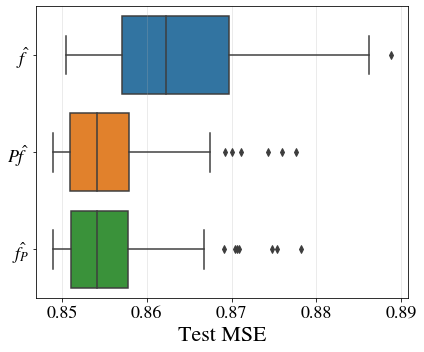

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.grid(alpha=0.3)
sns.boxplot(data=scores_df, orient='h', ax=ax)

ax.set_xlabel("Test MSE", fontsize=22)
ax.set_yticklabels([r'$\hatf$', r'$P\hatf$', r'$\hat{f_P}$'])
ax.set_yticklabels([r'$\hatf$', r'$P\hatf$', r'$\hat{f_P}$'])
ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()

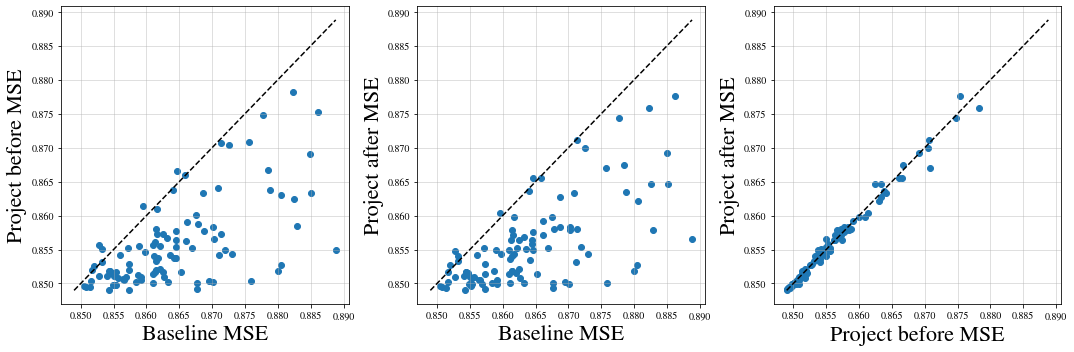

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fontsize = 22

t = np.linspace(scores_df.values.min(), scores_df.values.max())

ax[0].plot(t, t, 'k--')
ax[0].scatter(scores_df.baseline, scores_df.before)
ax[0].grid(alpha=0.5)
ax[0].set_xlabel("Baseline MSE", fontsize=fontsize)
ax[0].set_ylabel("Project before MSE", fontsize=fontsize)

ax[1].plot(t, t, 'k--')
ax[1].scatter(scores_df.baseline, scores_df.after)
ax[1].grid(alpha=0.5)
ax[1].set_xlabel("Baseline MSE", fontsize=fontsize)
ax[1].set_ylabel("Project after MSE", fontsize=fontsize)

ax[2].plot(t, t, 'k--')
ax[2].scatter(scores_df.before, scores_df.after)
ax[2].grid(alpha=0.5)
ax[2].set_xlabel("Project before MSE", fontsize=fontsize)
ax[2].set_ylabel("Project after MSE", fontsize=fontsize)

plt.tight_layout()
plt.show()

In [41]:
def paired_wilcoxon(df):
    cols = df.columns
    W_values = np.zeros((len(cols), len(cols)))
    p_values = np.zeros((len(cols), len(cols)))
    for i, j in combinations(range(len(cols)), 2):
        W, p = wilcoxon(x=df[cols[i]].values,
                        y=df[cols[j]].values)
        W_values[i, j] = W
        p_values[i, j] = p
    W_values =  W_values + W_values.T - np.eye(len(cols))
    p_values = p_values + p_values.T - np.eye(len(cols))
    W_df = pd.DataFrame(data=W_values, columns=cols, index=cols)
    p_df = pd.DataFrame(data=p_values, columns=cols, index=cols)
    return W_df, p_df

W_df, p_df_mse = paired_wilcoxon(scores_df)
p_df_mse

,baseline,after,before
baseline,-1.000000e+00,1.903451e-17,3.641680e-17
after,1.903451e-17,-1.000000e+00,2.704672e-02
before,3.641680e-17,2.704672e-02,-1.000000e+00


### n_train experiment

In [46]:
dirpaths = glob('../experiments/data/outputs/n_train/FaIR_experiment/*')
scores = {'baseline':[], 'after':[], 'before':[], 'ntrain': [], 'seed': []}
for dirpath in dirpaths:
    tokens = dirpath.split('/')[-1].split('_')
    seed, ntrain = int(tokens[1]), float(tokens[-1])
    with open(os.path.join(dirpath, 'scores.metrics'), "r") as f:
        foo = yaml.safe_load(f)
        scores['baseline'].append(foo['baseline'])
        scores['after'].append(foo['after'])
        scores['before'].append(foo['before'])
        scores['ntrain'].append(ntrain)
        scores['seed'].append(seed)
scores_df = pd.DataFrame(scores)
scores_df = scores_df.drop('seed', axis=1).groupby('ntrain').aggregate(['mean', 'std'])

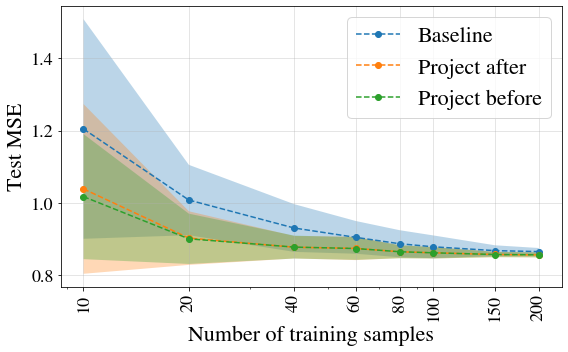

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fontsize = 22
legendsize = 22
labelsize = 18

ntrain = scores_df.index.values.astype(int)

baseline_mean = scores_df.baseline['mean']
baseline_ub = baseline_mean + scores_df.baseline['std']
baseline_lb = baseline_mean - scores_df.baseline['std']

after_mean = scores_df.after['mean']
after_ub = after_mean + scores_df.after['std']
after_lb = after_mean - scores_df.after['std']

before_mean = scores_df.before['mean']
before_ub = before_mean + scores_df.before['std']
before_lb = before_mean - scores_df.before['std']


ax.plot(ntrain, baseline_mean, ls='--', marker='o', label='Baseline')
ax.fill_between(ntrain, baseline_lb, baseline_ub, alpha=0.3)

ax.plot(ntrain, after_mean, ls='--', marker='o', label='Project after')
ax.fill_between(ntrain, after_lb, after_ub, alpha=0.3)

ax.plot(ntrain, before_mean, ls='--', marker='o', label='Project before')
ax.fill_between(ntrain, before_lb, before_ub, alpha=0.3)

ax.set_xscale('log')
ax.set_xticks(ntrain)
ax.set_xticklabels(ntrain, rotation=90)
ax.tick_params(labelsize=12)

ax.set_ylabel("Test MSE", fontsize=fontsize)
ax.set_xlabel('Number of training samples', fontsize=fontsize)


ax.grid(alpha=0.4)
ax.tick_params(labelsize=labelsize)
plt.legend(fontsize=legendsize)
plt.tight_layout()
plt.show()